In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

from math import sqrt
from sklearn.metrics import mean_squared_error

In [47]:
# Load AIR PASSENGERS data

air_passengers_data = pd.read_csv(r"D:\time_series_session\AirPassengers.csv")

In [48]:
# Reindexing for the timestamp Column

air_passengers_data['Passengers'] = air_passengers_data['#Passengers']
air_passengers_data.drop(columns=['#Passengers'], inplace=True)

air_passengers_data['Month'] = pd.to_datetime(air_passengers_data['Month'])
air_passengers_data.set_index('Month', inplace=True)

In [6]:
# Check for the Missing Values
temp_idx = pd.date_range( min(air_passengers_data.index), max(air_passengers_data.index), freq='MS' )
missing_values_length = len(temp_idx) - len(air_passengers_data)

missing_values_length

0

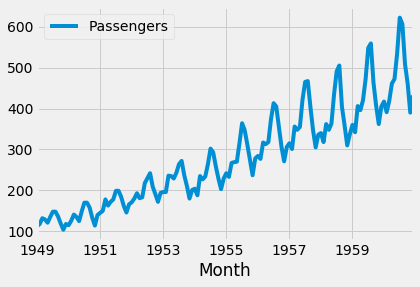

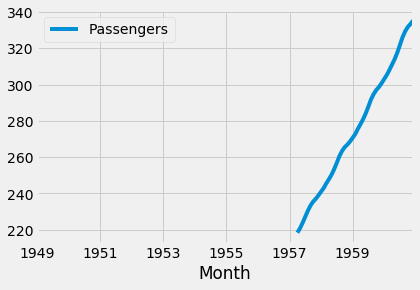

In [51]:
# Sample plotting the Data
air_passengers_data.plot()

#air_passengers_data.rolling(12).mean().plot()

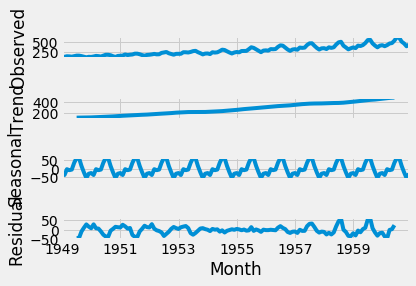

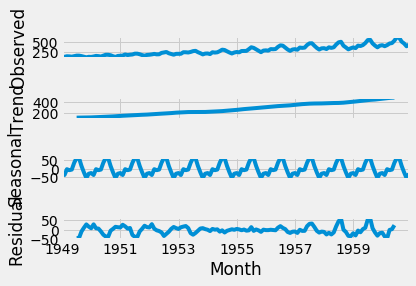

In [52]:
# Seasonal Decomposition of Data

decomposed_data = sm.tsa.seasonal_decompose(air_passengers_data['Passengers'], model='additive')

decomposed_data.plot()

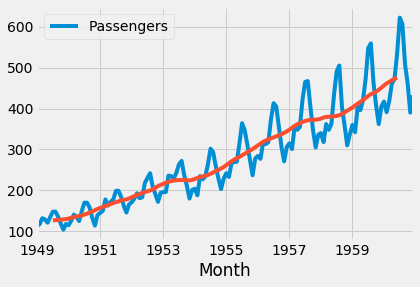

In [9]:
# Plotting the Trend, Seasonality & Residual from the Decomposed Data

air_passengers_data.plot()
decomposed_data.trend.plot()
#decomposed_data.seasonal.plot()
#decomposed_data.resid.plot()

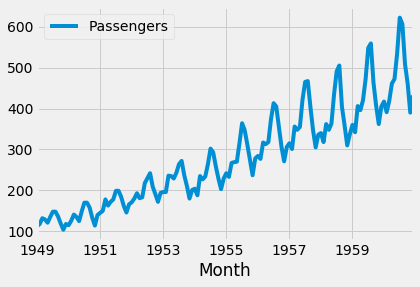

In [10]:
# Plotting Trend using Normal Calculation Methods

air_passengers_data.plot()
#air_passengers_data.rolling(12).mean().plot()

In [53]:
# Check for Stationarity

# Method to Perform Augmented Dickey-Fuller Test

def adf_test(df):

    dftest = adfuller(df, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [15]:
# Perform ADF for Non-Stationary Data

adf_test(air_passengers_data['Passengers'])

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [54]:
# STEP = 1 ------ DE-TREND

# Logarithmic Conversion ----- Removing the TREND
log_conv_air_passenger_data = np.log( air_passengers_data['Passengers'] )

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


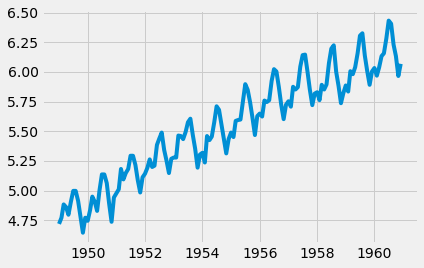

In [17]:
# Check Stationarity for De-Trended Data
adf_test(log_conv_air_passenger_data)
plt.plot(log_conv_air_passenger_data)

In [55]:
# Try smoothing Techniques

#--- 1 Moving Average
log_mov_average = log_conv_air_passenger_data.rolling(12).mean()

log_minus_mov_avg = log_conv_air_passenger_data - log_mov_average

In [56]:
#--- Drop the NaN values & consider the remaining values
log_minus_mov_avg.dropna(inplace=True)

# Check the stationarity of the remaining data
adf_test(log_minus_mov_avg)

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [22]:
### -- Calculate the Estimated Moving Average

log_ema = log_conv_air_passenger_data.ewm(halflife=12).mean()

#plt.plot(log_conv_air_passenger_data)
#plt.plot(log_ema)

log_ema_minus_log_conv = log_conv_air_passenger_data - log_ema

In [64]:
### Check Stationarity of the EMA differenced value

adf_test(log_ema_minus_log_conv)

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


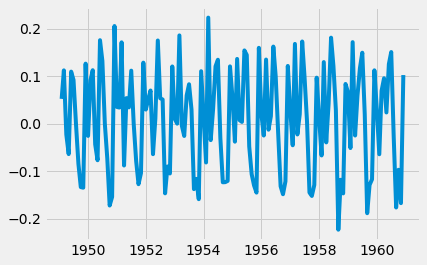

In [23]:
### To Remove Seasonality

log_minus_shift1 = log_conv_air_passenger_data - log_conv_air_passenger_data.shift()

#plt.plot(log_conv_air_passenger_data)
plt.plot(log_minus_shift1)

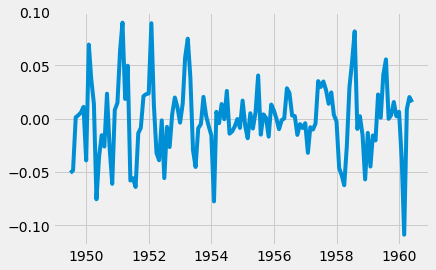

In [45]:
### Check the Stationarity of the Seasonal Data -- You can also alternatively use SEASONAL DECOMPOSE

log_minus_shift1.dropna(inplace=True)

log_decompose = sm.tsa.seasonal_decompose(log_conv_air_passenger_data, model='additive')

#plt.plot(log_decompose.seasonal)
#plt.plot(log_decompose.resid)
#plt.plot(log_minus_shift1)

### Check the Stationarity of the DIFFERENCED DATA
#adf_test(log_minus_shift1)

In [61]:
### Check the Stationarity of the Residual Data
residual_data = log_decompose.resid
residual_data.dropna(inplace=True)

adf_test(residual_data)

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


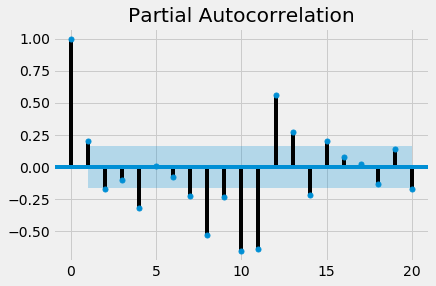

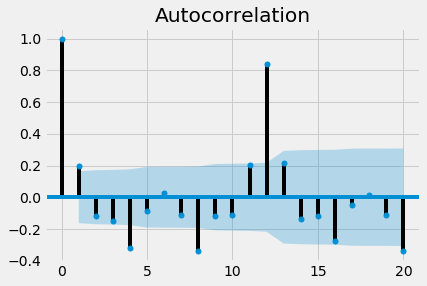

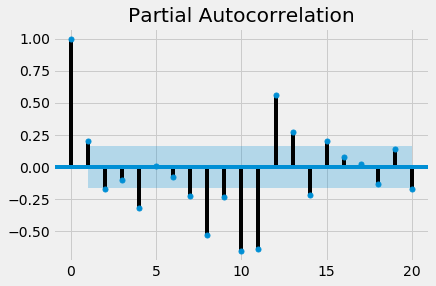

In [26]:
# Plotting the ACF & P-ACF for the logged data

plot_acf(log_minus_shift1, lags=20)
plot_pacf(log_minus_shift1, lags=20)

In [87]:
# Calculate the RMSE

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
# Calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Text(0.5, 1.0, 'RMSE: 0.1025')

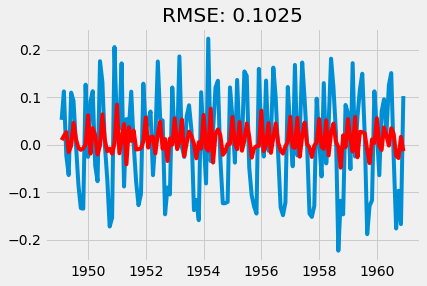

In [30]:
# Build an AR Model

AR_Model  = ARIMA(log_conv_air_passenger_data, order=(2,1,0))
result_AR = AR_Model.fit(disp=1)
plt.plot(log_minus_shift1)
plt.plot(result_AR.fittedvalues, color='red')
plt.title('RMSE: %.4f' % rmse(result_AR.fittedvalues, log_minus_shift1))

Text(0.5, 1.0, 'RMSE: 0.1015')

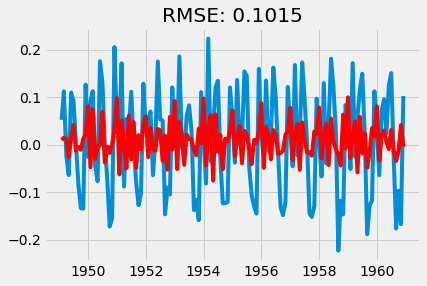

In [31]:
# Build an MA Model

MA_Model  = ARIMA(log_conv_air_passenger_data, order=(0,1,2))
result_MA = MA_Model.fit(disp=1)
plt.plot(log_minus_shift1)
plt.plot(result_MA.fittedvalues, color='red')
plt.title('RMSE: %.4f' % rmse(result_MA.fittedvalues, log_minus_shift1))

Text(0.5, 1.0, 'RMSE: 0.0848')

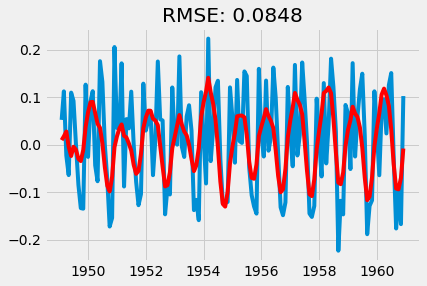

In [32]:
# Build an AR-I-MA Model

ARIMA_Model  = ARIMA(log_conv_air_passenger_data, order=(2,1,2))
result_ARIMA = ARIMA_Model.fit(disp=1)
plt.plot(log_minus_shift1)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('RMSE: %.4f' % rmse(result_ARIMA.fittedvalues, log_minus_shift1))

In [62]:
# Convert the data to its Original Format

## Predicted RESULT === DIFFERENCED value. So first Store them & name them properly
ARIMA_predictions_differenced = pd.Series( result_ARIMA.fittedvalues, copy=True )

ARIMA_predictions_differenced[:10]

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
1949-07-01   -0.004347
1949-08-01   -0.010978
1949-09-01   -0.029929
1949-10-01   -0.034467
1949-11-01   -0.011279
dtype: float64

In [63]:
## Find the Cumulative SUM --- To add the DIFFERENCES WE SUBTRACTED
ARIMA_predictions_differenced_cumsum = ARIMA_predictions_differenced.cumsum()

ARIMA_predictions_differenced_cumsum[:10]

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
1949-07-01    0.021985
1949-08-01    0.011007
1949-09-01   -0.018922
1949-10-01   -0.053389
1949-11-01   -0.064668
dtype: float64

In [65]:
#Form a DATAFRAME that represents the Initial LOG CONVERTED VALUES

recreated_log_ARIMA_data = pd.Series( log_conv_air_passenger_data[0], index=log_conv_air_passenger_data.index )
recreated_log_ARIMA_data = recreated_log_ARIMA_data.add( ARIMA_predictions_differenced_cumsum, fill_value = 0 )

#log_conv_air_passenger_data[0]
recreated_log_ARIMA_data[:5]

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

In [38]:
# ESTIMATE the FINAL PREDICTION to match with the ACTUAL value

# ---- Take an Exponential of the recreated_log_ARIMA
actual_predictions = np.exp( recreated_log_ARIMA_data )

Text(0.5, 1.0, 'RMSE: 165.5227')

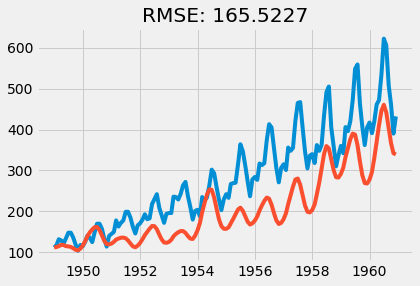

In [42]:
# Plot & validate the ACTUALs vs PREDICTIONS
plt.plot( air_passengers_data )
plt.plot( actual_predictions )

rmse_val = rmse( actual_predictions.values, air_passengers_data.values )
plt.title( 'RMSE: %.4f' % rmse_val.astype(float) )

Text(0.5, 1.0, 'RMSE: 0.0848')

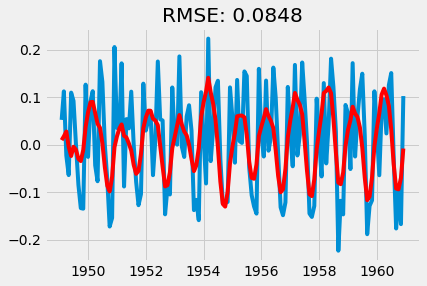

In [46]:
## Lets try building Model with DIFFERENCED data

ARIMA_Model_lat  = ARIMA(log_minus_shift1, order=(2,0,2))
result_ARIMA_lat = ARIMA_Model_lat.fit(disp=1)
plt.plot(log_minus_shift1)
plt.plot(result_ARIMA_lat.fittedvalues, color='red')
plt.title('RMSE: %.4f' % rmse(result_ARIMA_lat.fittedvalues, log_minus_shift1))